# Imports

In [1]:
# calculate parameters imports
import pyomo.environ as pyo
import math
import copy

# main code imports
import pyomo.environ as pyo

from idaes.core.util.model_statistics import (
    number_variables,
    number_total_equalities,
    number_total_inequalities,
    number_total_constraints,
    number_unfixed_variables,
    number_activated_constraints,
    report_statistics
)

# piecewise linear constraint imports
### Create piecewise-linear constraints for CAPEX vs maxFlow
from CapexParams import CAPEXParams

# for throwing errors
import sys

# for plotting
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate Parameters

In [2]:
def define_params(
    ###################################################################
    # Sensitivity analysis costing params
    CAPEX_param=1,
    OC_param=1,
    ###################################################################
    CR=0.15,  # collection rate
    HD_sens=1,  # Hydrogen Decrepitation yield sensitivity analysis
    AFDE_sens=0.98,  # Acid-free dissolution extraction yield sensitivity analysis
    auto_eff=0.15,  # how much more efficient automatic dissasembly is than manual disassembly
    Price_sensitivity=1,  # price of REO product sensitivity parameter
    gas_HD_eff=0.5, # efficiency of the gas-fired hydrogen decrepitation unit
):

    # number of levels
    numStages = 5
    Options_in_stage = {1: 2, 2: 4, 3: 4, 4: 4, 5: 4}
    maxOptions = max(Options_in_stage.values())

    # set of options k' in stage j+1 connected to option k in stage j
    Option_outlets = {
        # level 1
        (1, 1): [1, 2, 3, 4],
        (1, 2): [1, 2, 3, 4],
        # level 2
        (2, 1): [1, 2, 4],
        (2, 2): [1, 2, 4],
        (2, 3): [1, 2, 4],
        (2, 4): [3],
        # level 3
        (3, 1): [1],
        (3, 2): [2, 3],
        (3, 3): [2, 3],
        (3, 4): [4],
        # level 4
        (4, 1): [1],
        (4, 2): [2],
        (4, 3): [3],
        (4, 4): [4],
    }

    # Total flow into the plant. 2024 through 2038
    HEV_input_flow = {
        2025: 290273,
        2026: 274648,
        2027: 286512,
        2028: 487819,
        2029: 592637,
        2030: 571054,
        2031: 498472,
        2032: 506565,
        2033: 566355,
        2034: 669094,
        2035: 719057,
        2036: 762656,
        2037: 1434637,
        2038: 1697805,
    }

    HEV_feed = copy.deepcopy(HEV_input_flow)

    for key in HEV_feed.keys():
        HEV_feed[key] = HEV_input_flow[key] * CR

    maxFeed = max(HEV_feed.values())
    maxFeedYear = max(HEV_feed, key=HEV_feed.get)
    # print(HEV_feed)
    # define key components
    Key_comps = ["Nd", "Dy", "Fe"]

    # mass (kg) of each key component per HEV
    # assume 3 kg per
    HEV_comp_mass = {"Nd": 0.206 * 3, "Dy": 0.103 * 3, "Fe": 0.691 * 3}

    # dictionary of option and efficiency for each component.
    ### defining efficienies:
    # manual and automatic disassembly efficiency (all of j=1): 100%
    # hydrogen decrepitation and heating and extreme heating (all of j=2): 100%
    # acid dissolution and hydrometallurgical extraction: 98.5% for REEs, 0% for Fe
    # copper nitrate dissolution: 0.98 for REEs, 0% for Fe
    # supercritical fluid extraction: 92.5% for Nd, 98% for Dy, 0% for Fe
    # selective leaching: 100% for REEs, 0% for Fe
    # solvent extraction: 100% for Nd, 89.9% for Dy, no Fe entering.
    # oxalic acid precipitation 3 & 4: 98% for REEs, no Fe entering.

    Option_Eff = {
        # Level 1 yields
        (1, 1): {"Nd": 1, "Dy": 1, "Fe": 1},
        (1, 2): {"Nd": 1, "Dy": 1, "Fe": 1},
        # level 2 yields
        (2, 1): {"Nd": HD_sens, "Dy": HD_sens, "Fe": HD_sens},
        (2, 2): {"Nd": 1, "Dy": 1, "Fe": 1},
        (2, 3): {"Nd": 1, "Dy": 1, "Fe": 1},
        (2, 4): {"Nd": 1, "Dy": 1, "Fe": 1},
        # level 3 yields
        (3, 1): {"Nd": 0.985, "Dy": 0.985, "Fe": 0},
        (3, 2): {"Nd": 0.925, "Dy": 0.98, "Fe": 0},
        (3, 3): {"Nd": 1, "Dy": 1, "Fe": 0},
        (3, 4): {"Nd": 1, "Dy": 1, "Fe": 1},
        # level 4 yields
        (4, 1): {"Nd": 1, "Dy": 1, "Fe": 1},
        (4, 2): {"Nd": 1, "Dy": 0.899, "Fe": 0},
        (4, 3): {"Nd": 1, "Dy": 1, "Fe": 1},
        (4, 4): {"Nd": 1, "Dy": 1, "Fe": 1},
        # level 5 yields
        (5, 1): {"Nd": 1, "Dy": 1, "Fe": 0},  # grouped together with hydrom. extrac.
        (5, 2): {"Nd": 0.98, "Dy": 0.98, "Fe": 0},
        (5, 3): {"Nd": 0.98, "Dy": 0.98, "Fe": 0},
        (5, 4): {
            "Nd": AFDE_sens,
            "Dy": AFDE_sens,
            "Fe": 0,
        },  # grouped together with Cu(NO3)2 diss.
    }

    ############################ Disassembly Parameters ############################
    man_dis_rate = 7868
    yearly_dis_rate = {  # vehicles/unit/yr
        (1, 1): man_dis_rate,
        (1, 2): math.floor(man_dis_rate / auto_eff),
    }

    print(yearly_dis_rate)

    # calculate the units needed for each disassembly option
    from math import ceil

    Dis_Units = copy.deepcopy(yearly_dis_rate)

    for key in yearly_dis_rate.keys():
        Dis_Units[key] = ceil(maxFeed / yearly_dis_rate[key])

    print("number of dis units")
    print(Dis_Units)

    RC = 200000
    # costs per disassembly unit
    CU = {
        (1, 1): 0,
        (1, 2): RC * CAPEX_param,
    }

    # Define the yearly cost per robot ($/unit*yr)
    YCR = 280

    # yearly variable costs per disassembly unit
    YCU = {
        (1, 1): 0,
        (1, 2): YCR * OC_param,
    }

    ############################ Operator Parameters ############################

    # number of operators per option
    num_workers = {
        ##############################################
        # for disassembly stage, its operators per unit
        (1, 1): {
            "operators": 1,
        },
        (1, 2): {
            "operators": 0,
        },
        ##############################################
        (2, 1): {
            "operators": 0.65,
        },
        (2, 2): {
            "operators": 0.65,
        },
        (2, 3): {
            "operators": 0.65,
        },
        (2, 4): {
            "operators": 0.65,
        },
        (3, 1): {
            "operators": 1.6,
        },
        (3, 2): {
            "operators": 1.3,
        },
        (3, 3): {
            "operators": 0.45,
        },
        (3, 4): {
            "operators": 1.15,
        },
        (4, 1): {
            "operators": 0,
        },
        (4, 2): {
            "operators": 1.3,
        },
        (4, 3): {
            "operators": 0,
        },
        (4, 4): {
            "operators": 0,
        },
        (5, 1): {
            "operators": 1.05,
        },
        (5, 2): {
            "operators": 0.75,
        },
        (5, 3): {
            "operators": 0.75,
        },
        (5, 4): {
            "operators": 1.15,
        },
    }

    ########################### Calculate the hydrogen decrepitation OC params ############################
    # gas_HD_eff = 0.5
    energy_data = np.array( # before efficiency. units of MMBTU/hr
        [
            0.0167840612727081,
            0.0673810480853261,
            0.113956100414689,
            0.145790125155248,
            0.193321728234016,
            0.311754123239351,
            0.415323570762387,
            0.556415590551056,
        ]
    )

    energy_data_eff = energy_data / gas_HD_eff
    # print(energy_data_eff)

    gas_HD_cost_hourly = energy_data_eff * 2.53
    # print(gas_HD_cost_hourly)

    gas_HD_cost_yearly = gas_HD_cost_hourly * 8000
    print('HD yearly cost:')
    print(gas_HD_cost_yearly)

    # reshape x data to be 2d
    yearly_flows = np.array([36480, 634240, 1434800, 2083760, 3171200, 6342400, 9513600, 14270400]).reshape((-1,1))

    gas_HD_model = LinearRegression().fit(yearly_flows, gas_HD_cost_yearly)
    r_sq = gas_HD_model.score(yearly_flows, gas_HD_cost_yearly)
    print('HD unit mode R-squared and params:')
    print(r_sq)
    print(gas_HD_model.intercept_)
    print(gas_HD_model.coef_[0])
    #######################################################################################################

    ############################ OPEX Parameters ############################
    # for all options excluding the disassembly stage, the OPEX costs are linearly related to the flow entering it.
    # OPEX = a*F_in + b*y
    N_OC_var = {
        # level 2
        (2, 1): {"a": 0.0053, "b": 7929.7},  # done!
        (2, 2): {"a": gas_HD_model.coef_[0]  * OC_param, "b": gas_HD_model.intercept_  * OC_param},  # done!
        (2, 3): {"a": 0.0034, "b": 0},  # done!
        (2, 4): {"a": 0.0117, "b": 0},  # done!
        # level 3
        (3, 1): {"a": 15.594, "b": 4e6},  # done!
        (3, 2): {"a": 1.8359, "b": 0},  # done!
        (3, 3): {"a": 3.7414, "b": 2378.6},  # done!
        (3, 4): {"a": 1.58 * OC_param, "b": 0 * OC_param},  # done!
        # level 4
        (4, 1): {"a": 0, "b": 0},  # done!
        (4, 2): {"a": 111.09, "b": 254606},  # done!
        (4, 3): {"a": 0, "b": 0},  # done!
        (4, 4): {"a": 0 * OC_param, "b": 0 * OC_param},  # done!
        # level 5
        (5, 1): {"a": 0.4997, "b": 89832},  # done!
        (5, 2): {"a": 9.8127, "b": 964921},  # done!
        (5, 3): {"a": 9.8127, "b": 964921},  # done!
        (5, 4): {"a": 2.17 * OC_param, "b": 0 * OC_param},  # done!
    }

    # from UKy report ($/kg) of REO, who got it from NETL Standard Price Deck
    REO_vals = {"Nd": 42 * Price_sensitivity, "Dy": 230 * Price_sensitivity, "Fe": 0}

    # conversion of kg REE/Fe to kg REO/Fe2O3
    REE_to_REO_Conversion = {"Nd": 1.664, "Dy": 1.147, "Fe": 1.43}

    # convert combine above two dictionaries into one to simplify profit calculations in superstructure.
    REE_vals = copy.deepcopy(REO_vals)
    for comp in Key_comps:
        REE_vals[comp] = REO_vals[comp] * REE_to_REO_Conversion[comp]

    # dictionary that holds level 5 node discounts
    # (b/c mixed REOs are discounted 35% -> 0.65), from UKy report
    # level 5 node number : discount
    Node_discount = {
        (5, 1): 0.65,
        (5, 2): 1,
        (5, 3): 0.65,
        (5, 4): 0.65,
    }

    Profit = dict.fromkeys(
        [(numStages, j) for j in pyo.RangeSet(Options_in_stage[numStages])]
    )
    for key in Profit.keys():
        Profit[key] = copy.deepcopy(REE_vals)

        for comp in Key_comps:
            Profit[key][comp] = REE_vals[comp] * Node_discount[key]


    # Environmental Impacts Matrix
    environ_impacts = {
        (1, 1): 0,
        (1, 2): 1000,

        (2, 1): 0,
        (2, 2): 1000,
        (2, 3): 600,
        (2, 4): 800,

        (3, 1): 600,
        (3, 2): 0,
        (3, 3): 800,
        (3, 4): 1000,

        (4, 1): 800,
        (4, 2): 0,
        (4, 3): 600,
        (4, 4): 1000,

        (5, 1): 800,
        (5, 2): 0,
        (5, 3): 600,
        (5, 4): 1000,
    }


    return (
        HEV_feed,
        maxFeed,
        maxFeedYear,
        Profit,
        N_OC_var,
        num_workers,
        CU,
        YCU,
        Option_Eff,
        Dis_Units,
        environ_impacts,
    )

# Main code

In [3]:
def run_model(
    ###################################################################################################
    # Superstructure formulation parameters
    numStages=5,
    Options_in_stage={1: 2, 2: 4, 3: 4, 4: 4, 5: 4},
    Option_outlets={
        # level 1
        (1, 1): [1, 2, 3, 4],
        (1, 2): [1, 2, 3, 4],
        # level 2
        (2, 1): [1, 2, 4],
        (2, 2): [1, 2, 4],
        (2, 3): [1, 2, 4],
        (2, 4): [3],
        # level 3
        (3, 1): [1],
        (3, 2): [2, 3],
        (3, 3): [2, 3],
        (3, 4): [4],
        # level 4
        (4, 1): [1],
        (4, 2): [2],
        (4, 3): [3],
        (4, 4): [4],
    },  # set of options k' in stage j+1 connected to option k in stage j
    ###################################################################################################
    ###################################################################################################
    # Plant Lifetime Parameters
    plant_start=2024,
    prod_start=2025,  # first year is construction
    plant_lifetime=15,  # lifetime of plant
    ###################################################################################################
    ###################################################################################################
    # Feed parameters
    HEV_feed=None,  # feed entering plant; dependent on collection rate
    maxFeed=None,  # max feed entering the plant
    maxFeedYear=None,  # year max feed enters the plant
    Key_comps=["Nd", "Dy", "Fe"],  # key components
    HEV_comp_mass={
        "Nd": 0.206 * 3,
        "Dy": 0.103 * 3,
        "Fe": 0.691 * 3,
    },  # nass of key component per hev
    motor_price=0, # price per motor ($/motor)
    ###################################################################################################
    ###################################################################################################
    # Costing Parameters
    LF=2.97,  # Lang Factor
    ATWACC=0.0577,  # discount rate. ATWACC of 5.77%
    i_OC_esc=0.03,  # opex, revenue (3%)
    i_CAP_esc=0.036,  # capex escalation rate (3.6%)
    f_exp=[0.1, 0.6, 0.3],  # capital expenditure schedule (10%, 60%, 30%)
    CAPEX_param=None,  # capital expense param
    ###################################################################################################
    ###################################################################################################
    # Operating Parameters
    Profit=None,  # profit per kg of product. Takes into account mixed vs indiv. and in terms of key components
    N_OC_var=None,  # operating cost parameters
    num_workers=None,  # number of operators per option
    labor_type=["operators"],  # type of labor considered
    labor_rates={"operators": 8000 * 38.20},  # rates per type of labor
    YCU=None,  # yearly variable costs per disassembly unit
    CU=None,  # costs per disassembly unit
    Option_Eff=None,  # option efficiency
    Dis_Units=None,  # no. dis. units per option
    Dis_Rate={
        (1, 1): 7868,
        (1, 2): 52453,
    },
    ###################################################################################################
    ###################################################################################################
    # Choice of objective function. Options are 'NPV' or 'COR'.capitalize
    obj_func=None,
    # conversion of kg REE/Fe to kg REO/Fe2O3
    REE_to_REO_Conversion={"Nd": 1.664, "Dy": 1.147, "Fe": 1.43},
    ###################################################################################################
    ###################################################################################################
    # environmental impacts matrix
    environ_impacts=None,
    epsilon=None,
):

    ###################################################################################################
    # Calculate Superstructure formulation parameters
    maxOptions = max(Options_in_stage.values())  # max options in any of the stages
    final_opt_list = [
        (numStages, j) for j in pyo.RangeSet(Options_in_stage[numStages])
    ]  # make a list of the options in the final stage
    ###################################################################################################

    ###################################################################################################
    # CalculatePlant Lifetime Parameters
    plant_end = plant_start + plant_lifetime - 1  # final year plant is in production
    plant_life_range = pyo.RangeSet(plant_start, plant_end)  # lifetime of the plant
    operational_range = pyo.RangeSet(
        prod_start, plant_end
    )  # operational lifetime of the plant
    ###################################################################################################

    m = pyo.ConcreteModel()
    b = pyo.ConcreteModel()

    if obj_func == "COR":
        m.COR = pyo.Var(domain=pyo.NonNegativeReals)

    def cash_flow_block_rule(b, t):

        # These sets will be used to define the flow vars
        b.J = pyo.RangeSet(numStages)  # number of stages
        b.K = pyo.RangeSet(maxOptions)  # max options in a stage
        b.KeyComps = pyo.Set(initialize=Key_comps)  # key components
        jk = []  # for declaring bin vars
        jkc = []  # for declaring flow vars
        for j in b.J:
            for k in pyo.RangeSet(Options_in_stage[j]):
                jk.append((j, k))
                for c in b.KeyComps:
                    jkc.append((j, k, c))


        # mass balance constraints and flows only present after construction is complete (1 year)
        # amount of EOL products chosen to be recycled
        b.P_entering = pyo.Var(domain=pyo.NonNegativeReals)

        # F is stream entering each stage (except last stage). indexed by j, c, t.
        # Thus,
        b.F_stages = pyo.RangeSet(1, numStages - 1)

        b.F = pyo.Var(b.F_stages * b.KeyComps, domain=pyo.NonNegativeReals)

        # F^in is stream entering each option
        # F^out is stream leaving each option
        b.FlowSet = pyo.Set(within=b.J * b.K * b.KeyComps, initialize=jkc)
        b.F_in = pyo.Var(b.FlowSet, domain=pyo.NonNegativeReals)
        b.F_out = pyo.Var(b.FlowSet, domain=pyo.NonNegativeReals)

        # set of options
        b.OptSet = pyo.Set(within=b.J * b.K, initialize=jk)

        ### Mass Balances
        b.init_flow_cons = pyo.ConstraintList()  # eqn. 2
        b.inlet_flow_cons = pyo.ConstraintList()  # eqn. 1
        b.interm_flow_cons = pyo.ConstraintList()  # eqn. 3
        b.outlet_flow_cons = pyo.ConstraintList()  # eqn. 4

        b.inlet_flow_cons.add(expr=m.plantYear[t].P_entering == HEV_feed[t])


        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])

            if j == 1:
                # eqn. 2
                for c in b.KeyComps:
                    b.init_flow_cons.add(
                        expr=b.P_entering * HEV_comp_mass[c]
                        == sum(b.F_in[j, k, c] for k in num_options)
                    )

            else:
                # eqn. 1
                for c in b.KeyComps:
                    b.inlet_flow_cons.add(
                        expr=b.F[j - 1, c]
                        == sum(b.F_in[j, k, c] for k in num_options)
                    )

            if j != numStages:
                # eqn. 4
                for c in b.KeyComps:
                    b.outlet_flow_cons.add(
                        expr=sum(b.F_out[j, k, c] for k in num_options) == b.F[j, c]
                    )

        # eqn. 3
        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])
            for k in num_options:
                for c in b.KeyComps:
                    a = Option_Eff[(j, k)][c]
                    b.interm_flow_cons.add(
                        expr=b.F_in[j, k, c] * a == b.F_out[j, k, c]
                    )

        ### consideration of yearly environmental impacts
        b.total_yearly_GWP = pyo.Var(domain=pyo.NonNegativeReals)
        b.yearly_GWP = pyo.Var(b.OptSet, domain=pyo.NonNegativeReals)
        b.GWP_cons = pyo.ConstraintList()

        # calculate GWP associated with each technology option
        for j in b.J:
            num_options = pyo.RangeSet(Options_in_stage[j])
            for k in num_options:
                b.GWP_cons.add(expr= b.yearly_GWP[j,k] == sum(b.F_in[j,k,c] for c in b.KeyComps) * environ_impacts[j,k])

        # calculate the total GWP for the year
        b.GWP_cons.add(expr= b.total_yearly_GWP == sum(b.yearly_GWP[elem] for elem in b.OptSet))



    # build mass balance constraints for each year the plant is in operation.
    m.plant_year = pyo.RangeSet(prod_start, plant_end)
    m.plantYear = pyo.Block(m.plant_year, rule=cash_flow_block_rule)


    # These sets will be used to define the binary and flow vars
    m.J = pyo.RangeSet(numStages)  # number of stages
    m.K = pyo.RangeSet(maxOptions)  # max options in a stage
    m.KeyComps = pyo.Set(initialize=Key_comps)  # key components
    jk = []  # for declaring bin vars
    jkc = []  # for declaring flow vars
    for j in m.J:
        for k in pyo.RangeSet(Options_in_stage[j]):
            jk.append((j, k))
            for c in m.KeyComps:
                jkc.append((j, k, c))

    ### declare binary variables
    m.OptSet = pyo.Set(within=m.J * m.K, initialize=jk)
    m.binOpt = pyo.Var(m.OptSet, domain=pyo.Binary)

    ### Logical Constraints
    # eqn. 5
    m.stage_bin_cons = pyo.ConstraintList()
    for j in m.J:
        num_options = pyo.RangeSet(Options_in_stage[j])
        m.stage_bin_cons.add(expr=sum(m.binOpt[j, k] for k in num_options) == 1)

    # eqn. 6
    m.connect_bin_cons = pyo.ConstraintList()
    j = 0
    for j in pyo.RangeSet(1, numStages - 1):
        num_options = pyo.RangeSet(Options_in_stage[j])

        k = 0
        for k in num_options:
            opt_connects = Option_outlets[(j, k)]
            m.connect_bin_cons.add(
                expr=1
                - m.binOpt[j, k]
                + sum(m.binOpt[j + 1, kp] for kp in opt_connects)
                >= 1
            )

    ## big-M constraints
    m.big_M_cons = pyo.ConstraintList()
    M = {"Nd": 0, "Dy": 0, "Fe": 0}
    val = 0
    for c in m.KeyComps:
        val = maxFeed * HEV_comp_mass[c]
        M[c] = val*10

    for t in pyo.RangeSet(prod_start, plant_end):
        for j in m.J:
            num_options = pyo.RangeSet(Options_in_stage[j])

            for k in num_options:
                for c in m.KeyComps:
                    m.big_M_cons.add(
                        expr=m.plantYear[t].F_in[j, k, c] <= m.binOpt[j, k] * M[c]
                    )  # eqn. 7
                    m.big_M_cons.add(
                        expr=m.plantYear[t].F_out[j, k, c] <= m.binOpt[j, k] * M[c]
                    )  # eqn. 8

    # define disassembly works set
    m.J_dis = pyo.RangeSet(1)  # number of stages
    m.K_dis = pyo.RangeSet(maxOptions)  # max options in a stage
    max_dis_workers = Dis_Units[1, 1] + 10
    dis_workers_range = pyo.RangeSet(0, max_dis_workers)
    jk_dis = []
    jkw_dis = []  # for declaring bin vars
    for j_dis in m.J_dis:
        for k_dis in pyo.RangeSet(Options_in_stage[j_dis]):
            jk_dis.append((j_dis, k_dis))
            for w_dis in dis_workers_range:
                jkw_dis.append((j_dis, k_dis, w_dis))

    m.disOpts = pyo.Set(within=m.J_dis * m.K_dis, initialize=jk_dis)
    m.DisOptWorkersSet = pyo.Set(
        within=m.J_dis * m.K_dis * dis_workers_range, initialize=jkw_dis
    )
    m.DisOptWorkers = pyo.Var(m.DisOptWorkersSet, domain=pyo.Binary)

################################################ Cash Flow Constraints ################################################
    m.OC_var_cons = pyo.ConstraintList()
    m.DisWorkerCons = pyo.ConstraintList() # for the disassembly stage
     # calculate profit
    m.final_opt_set = pyo.Set(
        initialize=final_opt_list
    )  # list of final node list
    m.profit_opt_cons = pyo.ConstraintList()

    # opex and profit only calculated once production starts
    for t in pyo.RangeSet(prod_start, plant_end):
        m.plantYear[t].OC_var = pyo.Var(m.OptSet, domain=pyo.Reals)

        # must be enough dis units to handle incoming feed each year.
        m.DisWorkerCons.add(
            expr=m.plantYear[t].P_entering
            <= sum(
                Dis_Rate[elem]
                * sum(i * m.DisOptWorkers[elem + (i,)] for i in dis_workers_range)
                for elem in m.disOpts
            )
        )

        for elem in m.disOpts:
            # only 1 'amount' of workers can be chosen.
            m.DisWorkerCons.add(
                expr=sum(m.DisOptWorkers[elem + (i,)] for i in dis_workers_range)
                == 1
            )

            # if a disassembly option is not chosen, then that 'amount' must be 0
            m.DisWorkerCons.add(
                expr=m.binOpt[elem] >= 1 - m.DisOptWorkers[elem + (0,)]
            )

        # calculate variable costs for disassembly stage
        j = 1
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            option = (j, k)
            m.OC_var_cons.add(
                expr=m.plantYear[t].OC_var[option]
                == sum(
                    m.DisOptWorkers[option + (i,)] * i for i in dis_workers_range
                )
                * YCU[option]
            )

        # calculate variable costs for rest of stages
        for elem in m.OptSet:
            j = 0
            k = 0
            j, k = elem
            if j > 1:  # already calculated opex for discretized options
                m.OC_var_cons.add(
                    expr=m.plantYear[t].OC_var[elem]
                    == N_OC_var[elem]["a"]
                    * sum(m.plantYear[t].F_in[elem + (c,)] for c in m.KeyComps)
                    + N_OC_var[elem]["b"] * m.binOpt[elem]
                )

        # calculate total variable cost
        m.plantYear[t].OC_var_total = pyo.Var(domain=pyo.Reals)
        m.OC_var_cons.add(
            expr=m.plantYear[t].OC_var_total == sum(m.plantYear[t].OC_var[elem] for elem in m.OptSet)
        )

        m.plantYear[t].ProfitOpt = pyo.Var(m.final_opt_set)

        if obj_func == "NPV":
            for opt in m.final_opt_set:
                m.profit_opt_cons.add(
                    expr=m.plantYear[t].ProfitOpt[opt]
                    == sum(m.plantYear[t].F_out[opt + (c,)] * Profit[opt][c] for c in m.KeyComps)
                )
        elif obj_func == "COR":
            for opt in m.final_opt_set:
                m.profit_opt_cons.add(
                    expr=m.plantYear[t].ProfitOpt[opt]
                    == sum(
                        m.plantYear[t].F_out[opt + (c,)] * REE_to_REO_Conversion[c]
                        for c in m.KeyComps
                    )
                    * m.COR
                )
                
        else:
            sys.exit("No objective function chosen.")

        m.plantYear[t].Profit = pyo.Var(domain=pyo.NonNegativeReals)
        m.plantYear[t].profit_con = pyo.Constraint(
            expr=m.plantYear[t].Profit == sum(m.plantYear[t].ProfitOpt[opt] for opt in m.final_opt_set)
        )

    


    ################################################ OC_fixed Constraints ################################################
    # calculate the cost of labor
    m.COL = pyo.Var(m.OptSet, domain=pyo.Reals)
    m.workers = pyo.Var(m.OptSet, domain=pyo.Reals)
    m.worker_cons = pyo.ConstraintList()
    m.COL_cons = pyo.ConstraintList()

    # calculate the number of workers for each stage
    max_dis_workers = Dis_Units[1, 1] + 10
    dis_workers_range = pyo.RangeSet(0, max_dis_workers)
    j = 0
    for j in pyo.RangeSet(1, numStages):
        k = 0
        elem = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)

            if j == 1:
                m.worker_cons.add(
                    expr=m.workers[j, k]
                    == sum(
                        i * m.DisOptWorkers[j, k, i]
                        for i in dis_workers_range
                    )
                    * num_workers[elem]["operators"]
                )

            else:
                m.worker_cons.add(
                    expr=m.workers[j, k]
                    == m.binOpt[j, k] * num_workers[elem]["operators"]
                )

    m.workers_range = pyo.RangeSet(0, Dis_Units[1, 1]+10)
    m.bin_workers = pyo.Var(m.workers_range, domain=pyo.Binary)
    m.total_workers = pyo.Var(domain=pyo.Reals)

    m.worker_cons.add(
        expr=sum(m.workers[elem] for elem in m.OptSet)
        <= sum(i * m.bin_workers[i] for i in m.workers_range)
    )
    m.worker_cons.add(expr=sum(m.bin_workers[i] for i in m.workers_range) == 1)

    m.worker_cons.add(
        expr=m.total_workers == sum(i * m.bin_workers[i] for i in m.workers_range)
    )

    # calculate total COL
    m.COL_Total = pyo.Var(domain=pyo.NonNegativeReals)
    m.COL_Total_con = pyo.Constraint(
        expr=m.COL_Total == m.total_workers * labor_rates["operators"]
    )

    ################################################ CAPEX Constraints ################################################
    t_max = maxFeedYear

    # TPC = BEC * LF
    # m.plantYear[t_capex].Opt_CAPEX = pyo.Var(m.plantYear[t_capex].OptSet, domain=pyo.NonNegativeReals)
    m.BEC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.BEC_cons = pyo.ConstraintList()

    # make a var for the max flow entering each option. Used to calculate capex
    maxFlowUB = maxFeed * sum(HEV_comp_mass[c] for c in Key_comps)
    m.BEC_max_flow = pyo.Var(m.OptSet, bounds=(0, maxFlowUB))
    m.BEC_max_flow_cons = pyo.ConstraintList()

    # Calculate disassembly BEC (disassembly stage is always the first stage)
    k = 0
    for k in pyo.RangeSet(Options_in_stage[1]):
        m.BEC_cons.add(
            expr=m.BEC[1, k]
            == sum(
                i * m.DisOptWorkers[1, k, i] for i in dis_workers_range
            )
            * CU[1, k]
        )

    # calculate BEC for rest of stages
    for elem in m.OptSet:
        j, k = elem
        if j > 1:  # already calculated capex for disassembly stage
            # calculate max flow stream for capex
            # find the max flow (flow must be >= all flows entering it)
            for t in pyo.RangeSet(prod_start, plant_end):
                m.BEC_max_flow_cons.add(
                    expr= m.BEC_max_flow[elem] >= sum(
                        m.plantYear[t].F_in[elem + (c,)]
                        for c in m.KeyComps
                    )
                )

    j = 0
    k = 0
    for j in pyo.RangeSet(2, numStages):
        for k in pyo.RangeSet(Options_in_stage[j]):
            # get x and y data
            flowData = 0  # x data
            CAPEXData = 0  # y data
            flowData, CAPEXData = CAPEXParams((j, k))

            # CAPEX sensitivity
            if elem in [(2, 2), (3, 4), (4, 4), (5, 4)]:
                CAPEXData = [x * CAPEX_param for x in CAPEXData]

            # use m.add_component to generate all piecewise functions
            # piecewise = Piecewise(yval, xval, *kwargs)
            piecewise = pyo.Piecewise(
                m.BEC[j, k],
                m.BEC_max_flow[j, k],
                pw_pts=flowData,
                pw_constr_type="EQ",
                f_rule=CAPEXData,
                pw_repn="SOS2",
            )
            optName = (j, k)
            print("Piecewise_Node" + str(optName))
            m.add_component("Piecewise_Node" + str(optName), piecewise)

    m.TPC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.TPC_cons = pyo.ConstraintList()
    # TPC for disassembly
    m.TPC_cons.add(expr=m.TPC[1, 1] == 0)  # no TPC for manual disassembly
    m.TPC_cons.add(expr=m.TPC[1, 2] == m.BEC[1, 2])
    # multiply all TPCs by lang factor
    j = 0
    for j in pyo.RangeSet(2, numStages):
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            m.TPC_cons.add(expr=m.TPC[j, k] == m.BEC[j, k] * LF)

    # calculate total TPC
    m.Total_TPC = pyo.Var(domain=pyo.NonNegativeReals)
    m.Total_TPC_con = pyo.Constraint(
        expr=m.Total_TPC == sum(m.TPC[elem] for elem in m.OptSet)
    )

    # calculate TOC
    m.TOC = pyo.Var(domain=pyo.NonNegativeReals)
    m.TOC_con = pyo.Constraint(
        expr=m.TOC == m.Total_TPC + 0.027 * m.Total_TPC + 0.15 * m.Total_TPC
    )

    # calculate node TOCs
    m.node_TOC = pyo.Var(m.OptSet, domain=pyo.NonNegativeReals)
    m.node_TOC_cons = pyo.ConstraintList()

    j = 0
    for j in pyo.RangeSet(1, numStages):
        k = 0
        for k in pyo.RangeSet(Options_in_stage[j]):
            elem = (j, k)
            m.node_TOC_cons.add(
                expr=m.node_TOC[elem]
                == m.TPC[elem] + 0.027 * m.TPC[elem] + 0.15 * m.TPC[elem]
            )

    #### construct cash flows
    m.CF = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.CF_cons = pyo.ConstraintList()
    ## CAPEX cons
    # yearly TOC expenditure
    m.TOC_exp = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.TOC_exp_cons = pyo.ConstraintList()

    ## OPEX cons
    # net earnings
    m.NE = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.NE_cons = pyo.ConstraintList()
    ### gross earnings
    m.GE = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.GE_cons = pyo.ConstraintList()
    ## calculate tax rate (0% if GE are negative)
    # binary for if GE is non-negative or not
    # m.bin_GE_pos = pyo.Var(P.plant_life_range, domain=pyo.Binary)
    # # tax rate based on GE
    # m.Tax_rate = pyo.Var(P.plant_life_range, domain=pyo.NonNegativeReals)
    # revenue
    m.Rev = pyo.Var(plant_life_range, domain=pyo.Reals)
    m.Rev_cons = pyo.ConstraintList()
    ## calculating depreciation
    # book value
    # m.BV = pyo.Var(P.plant_life_range, domain=pyo.Reals)
    # depreciation
    # m.Deprec = pyo.Var(P.plant_life_range, domain=pyo.Reals)
    # m.Deprec_cons = pyo.ConstraintList()
    # m.Deprec_cons.add(expr= m.BV[P.plant_start] == m.TOC)
    # amortization
    # m.Amort = pyo.Var(P.plant_life_range, domain=pyo.Reals)
    # m.Amort_cons = pyo.ConstraintList()
    # fixed operation costs
    m.OC_fixed = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.OC_fixed_cons = pyo.ConstraintList()
    # variable operating costs
    m.OC_var = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    # plant overhead costs
    m.OH = pyo.Var(plant_life_range, domain=pyo.NonNegativeReals)
    m.OH_cons = pyo.ConstraintList()

    t = 0
    for t in plant_life_range:
        # capital expenditure only in first three years
        if t <= (plant_start + 2):
            m.TOC_exp_cons.add(
                expr=m.TOC_exp[t]
                == ((1 + i_CAP_esc) ** (t - plant_start))
                * f_exp[t - plant_start]
                * m.TOC
            )
        else:
            # no capital escalation after third year
            m.TOC_exp_cons.add(expr=m.TOC_exp[t] == 0)
            # m.CF_cons.add(expr= m.CF[t] == m.plantYear[t].Profit - m.plantYear[t].OC_var_total - m.COL_Total)

        # opex and revenue only once production begins (starting second year)
        if prod_start <= t:
            # fixed operating costs
            m.OC_fixed_cons.add(
                expr=m.OC_fixed[t]
                == m.COL_Total
                + 0.02 * m.Total_TPC
                + 0.1 * m.COL_Total
                + 0.01 * m.plantYear[t].Profit
                + 0.2 * m.COL_Total
                + 0.25 * m.COL_Total
                + 0.01 * m.Total_TPC
            )

            # variable costs
            m.OC_var_cons.add(expr=m.OC_var[t] == m.plantYear[t].OC_var_total)

            # revenue
            m.Rev_cons.add(expr=m.Rev[t] == m.plantYear[t].Profit)

            # calculate depreciation
            # m.Deprec_cons.add(expr= m.Deprec[t] == m.BV[t - 1] * P.DR)
            # calculate new book value
            # m.Deprec_cons.add(expr= m.BV[t] == m.BV[t-1] - m.Deprec[t])
        else:
            m.OC_fixed_cons.add(expr=m.OC_fixed[t] == 0)
            m.OC_var_cons.add(expr=m.OC_var[t] == 0)
            m.Rev_cons.add(expr=m.Rev[t] == 0)
            # m.Deprec_cons.add(expr= m.Deprec[t] == 0)

        # # Calculate amortization (10 years, 6% interest)
        # if t < P.plant_start + 10:
        #     m.Amort_cons.add(expr= m.Amort[t] == P.UCRF * (0.5 * m.TOC))
        # else:
        #     m.Amort_cons.add(expr= m.Amort[t] == 0)

        # calculate plant overhead
        m.OH_cons.add(expr=m.OH[t] == 0.2 * (m.OC_fixed[t] + m.OC_var[t]))

        # calculate the gross earnings
        # m.GE_cons.add(expr= m.GE[t] == (m.Rev[t] - m.OC_fixed[t] - m.OC_var[t]) * (1 + P.i_esc)**(t - P.prod_start) - m.Amort[t])
        m.GE_cons.add(
            expr=m.GE[t]
            == (m.Rev[t] - m.OC_fixed[t] - m.OC_var[t] - m.OH[t])
            * (1 + i_OC_esc) ** (t - 2023)
        )

        # calculate tax rate based on the gross earnings (GE) in year t
        # m.GE_cons.add(expr= m.Tax_rate[t] == P.t_r * (1 - m.bin_GE_pos[t]))
        # m.GE_cons.add(expr= m.GE[t] <= P.maxPotProfits * (1 - m.bin_GE_pos[t]))

        # calculate the net earnings
        # m.NE_cons.add(expr= m.NE[t] == m.GE[t] * (1 - m.Tax_rate[t]) + m.Deprec[t] * m.Tax_rate[t])

        # calculate the cash flow
        # m.CF_cons.add(expr= m.CF[t] == m.NE[t] - m.TOC_exp[t])
        m.CF_cons.add(expr=m.CF[t] == m.GE[t] - m.TOC_exp[t])

    # Maximize NPV
    # def obj_rule(m):
    #     return sum(
    #         m.CF[t] / (1 + P.i_rate) ** (t - (P.plant_start - 1))
    #         for t in pyo.RangeSet(P.plant_start, P.plant_end)
    #     )

    # def obj_rule(m):
    #     return m.plantYear[2032].binOpt[5,4]

    ### testing
    m.bin_test_cons = pyo.ConstraintList()
    # m.bin_test_cons.add(expr= m.binOpt[1,1] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[2,4] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[3,3] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[4,3] == 1)
    # m.bin_test_cons.add(expr= m.binOpt[5,3] == 1)


    # # most economical solutions:\
    # # number 1
    # m.bin_test_cons.add(expr= m.binOpt[1,2] +
    #                     m.binOpt[2,2] +
    #                     m.binOpt[3,4] +
    #                     m.binOpt[4,4] +
    #                     m.binOpt[5,4] <= 4)
    
    # # number 2
    # m.bin_test_cons.add(expr= m.binOpt[1,1] +
    #                     m.binOpt[2,2] +
    #                     m.binOpt[3,4] +
    #                     m.binOpt[4,4] +
    #                     m.binOpt[5,4] <= 4)
    
    # # number 3
    # m.bin_test_cons.add(expr= m.binOpt[1,1] +
    #                     m.binOpt[2,1] +
    #                     m.binOpt[3,4] +
    #                     m.binOpt[4,4] +
    #                     m.binOpt[5,4] <= 4)
    
    # # number 4
    # m.bin_test_cons.add(expr= m.binOpt[1,2] +
    #                     m.binOpt[2,1] +
    #                     m.binOpt[3,4] +
    #                     m.binOpt[4,4] +
    #                     m.binOpt[5,4] <= 4)
    
    # # number 5
    # m.bin_test_cons.add(expr= m.binOpt[1,1] +
    #                     m.binOpt[2,3] +
    #                     m.binOpt[3,4] +
    #                     m.binOpt[4,4] +
    #                     m.binOpt[5,4] <= 4)
    
    



    # m.obj = pyo.Objective(expr=m.plantYear[2025].F_out[4, 5, "Nd"], sense=pyo.maximize)




    ### environmental impacts
    m.GWP = pyo.Var(domain=pyo.NonNegativeReals)
    m.GWP_cons = pyo.ConstraintList()

    m.GWP_cons.add(expr= m.GWP == sum(m.plantYear[t].total_yearly_GWP for t in pyo.RangeSet(prod_start, plant_end)))

    # add in epsilon constraint
    m.epsilon_con = pyo.Constraint(expr= m.GWP <= epsilon)

     

    if obj_func == "NPV":

        def obj_rule(m):
            return sum(
                m.CF[t] / (1 + ATWACC) ** (t - plant_start) for t in plant_life_range
            )

        m.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

    elif obj_func == "COR":
        m.NPV = pyo.Var(domain=pyo.Reals)
        m.NPV_con1 = pyo.Constraint(
            expr=m.NPV
            == sum(
                m.CF[t] / (1 + ATWACC) ** (t - plant_start) for t in plant_life_range
            )
        )
        m.NPV_con2 = pyo.Constraint(expr=m.NPV == 0)
        m.obj = pyo.Objective(expr=m.COR, sense=pyo.minimize)
    else:
        sys.exit("no objective function was specified")

    solver = pyo.SolverFactory("gurobi")
    solver.options["NumericFocus"] = 2

    # Enable the solution pool
    solver.options['PoolSearchMode'] = 2 # final all solutions within the gap
    solver.options['PoolSolutions'] = 10 # store up to 10 solutions in the pool
    solver.options['PoolGap'] = 0 # look for multiple solutions

    m.results = pyo.SolverFactory("gurobi").solve(m, tee=True)

    return m

# Base Case (no minimization of GWP)

In [4]:
CAPEX_param = 1
OC_param = 1
CR = 0.15
HD_sens = 1
AFDE_sens = 0.98
auto_eff = 0.15
Price_sensitivity = 1
epsilon = 1000000000000000
# epsilon = 10000

(
    HEV_feed,
    maxFeed,
    maxFeedYear,
    Profit,
    N_OC_var,
    num_workers,
    CU,
    YCU,
    Option_Eff,
    Dis_Units,
    environ_impacts,
) = define_params(
    CAPEX_param=CAPEX_param,
    OC_param=OC_param,
    CR=CR,
    HD_sens=HD_sens,
    AFDE_sens=AFDE_sens,
    auto_eff=auto_eff,
    Price_sensitivity=Price_sensitivity,
)

results_NPV = run_model(
    ##################################################################################################
    # Superstructure formulation parameters
    # numStages = 5,
    # Options_in_stage = {1: 2, 2: 3, 3: 4, 4: 4, 5: 4},
    # Option_outlets = {
    #     # level 1
    #     (1, 1): [1, 2, 3],
    #     (1, 2): [1, 2, 3],
    #     # level 2
    #     (2, 1): [1, 2, 4],
    #     (2, 2): [1, 2, 4],
    #     (2, 3): [3],
    #     # level 3
    #     (3, 1): [1],
    #     (3, 2): [2,3],
    #     (3, 3): [2, 3],
    #     (3, 4): [4],
    #     # level 4
    #     (4, 1): [1],
    #     (4, 2): [2],
    #     (4, 3): [3],
    #     (4, 4): [4],
    # }, # set of options k' in stage j+1 connected to option k in stage j
    ###################################################################################################
    ###################################################################################################
    # Plant Lifetime Parameters
    # plant_start = 2024,
    # prod_start = 2025, # first year is construction
    # plant_lifetime = 15, # lifetime of plant
    ###################################################################################################
    ###################################################################################################
    # Feed parameters
    HEV_feed=HEV_feed,  # feed entering plant; dependent on collection rate
    maxFeed=maxFeed,  # max feed entering the plant
    maxFeedYear=maxFeedYear,  # year max feed enters the plant
    # Key_comps = ["Nd", "Dy", "Fe"], # key components
    # HEV_comp_mass = {"Nd": 0.206*3, "Dy":0.103*3, "Fe": 0.691*3}, # nass of key component per hev
    ###################################################################################################
    ###################################################################################################
    # Costing Parameters
    # LF = 2.97, # Lang Factor
    # ATWACC = 0.0577, # discount rate. ATWACC of 5.77%
    # i_OC_esc = 0.03, # opex, revenue (3%)
    # i_CAP_esc = 0.036, # capex escalation rate (3.6%)
    # f_exp = [0.1, 0.6, 0.3], # capital expenditure schedule (10%, 60%, 30%)
    CAPEX_param=CAPEX_param,  # capital expense param
    ###################################################################################################
    ###################################################################################################
    # Operating Parameters
    Profit=Profit,  # profit per kg of product. Takes into account mixed vs indiv. and in terms of key components
    N_OC_var=N_OC_var,  # operating cost parameters
    num_workers=num_workers,  # number of operators per option
    # labor_type = ["operators"], # type of labor considered
    # labor_rates = {"operators": 8000 * 38.20}, # rates per type of labor
    YCU=YCU,  # yearly variable costs per disassembly unit
    CU=CU,  # costs per disassembly unit
    Option_Eff=Option_Eff,  # option efficiency
    Dis_Units=Dis_Units,  # no. dis. units per option
    ###################################################################################################
    obj_func="NPV",
    # obj_func="COR",
    ###################################################################################################
    # environmental impacts matrix
    environ_impacts=environ_impacts,
    epsilon=epsilon,
)

# results_NPV.obj.display()
results_NPV.total_workers.display()

# print('degrees of freedom:')
# print(number_variables(results_NPV))
# print(number_total_equalities(results_NPV))
# print(number_total_inequalities(results_NPV))
# # print(number_total_constraints(results))
# print(number_variables(results_NPV) - number_total_equalities(results_NPV))
# report_statistics(results_NPV)

results_NPV.display()


{(1, 1): 7868, (1, 2): 52453}
number of dis units
{(1, 1): 33, (1, 2): 5}
HD yearly cost:
[  679.41880032  2727.58482649  4612.94294479  5901.58426628
  7825.66355891 12619.80690873 16812.29814446 22523.70310551]
HD unit mode R-squared and params:
0.985072966561252
2233.1628528501988
0.001489526461863264
Piecewise_Node(2, 1)
Piecewise_Node(2, 2)
Piecewise_Node(2, 3)
Piecewise_Node(2, 4)
Piecewise_Node(3, 1)
Piecewise_Node(3, 2)
Piecewise_Node(3, 3)
Piecewise_Node(3, 4)
Piecewise_Node(4, 1)
**WARNING: Piecewise component ''Piecewise_Node(4, 1)'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Piecewise_Node(4, 2)
Piecewise_Node(4, 3)
**WARNING: Piecewise component ''Piecewise_Node(4, 3)'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how 

# Display NPV

In [5]:
results_NPV.display()
results_NPV.obj.display()

Model unknown

  Variables:
    binOpt : Size=18, Index=OptSet
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 4) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1) :     0 :   0.0 :     1 : False : False : Binary
        (3, 2) :     0 :   0.0 :     1 : False : False : Binary
        (3, 3) :     0 :   0.0 :     1 : False : False : Binary
        (3, 4) :     0 :   1.0 :     1 : False : False : Binary
        (4, 1) :     0 :   0.0 :     1 : False : False : Binary
        (4, 2) :     0 :   0.0 :     1 : False : False : Binary
        (4, 3) :     0 :   0.0 :     1 : False : False : Binary
        (4, 4) :     0 :   1.0 :     1 : 

# Display GWP

In [6]:
results_NPV.GWP.display()

GWP : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 21054563999.999985 :  None : False : False : NonNegativeReals


# Define parameters 

In [7]:
numStages = 5
Options_in_stage = {1: 2, 2: 4, 3: 4, 4: 4, 5: 4}
Option_outlets = {
    # level 1
    (1, 1): [1, 2, 3, 4],
    (1, 2): [1, 2, 3, 4],
    # level 2
    (2, 1): [1, 2, 4],
    (2, 2): [1, 2, 4],
    (2, 3): [1, 2, 4],
    (2, 4): [3],
    # level 3
    (3, 1): [1],
    (3, 2): [2, 3],
    (3, 3): [2, 3],
    (3, 4): [4],
    # level 4
    (4, 1): [1],
    (4, 2): [2],
    (4, 3): [3],
    (4, 4): [4],
}

plant_start = 2024
prod_start = 2025 # first year is construction
plant_lifetime = 15 # lifetime of plant
plant_end = plant_start + plant_lifetime - 1  # final year plant is in production

Key_comps = ["Nd", "Dy", "Fe"]
# KeyComps = pyo.Set(initialize=Key_comps)  # key components




# Check which options were chosen for the base case.

In [8]:
# store active options
ActiveOptSet = []

t = 2032
for j in pyo.RangeSet(1, numStages):
    for k in pyo.RangeSet(Options_in_stage[j]):
        option = pyo.value(results_NPV.binOpt[j, k])
        if math.isclose(option, 1):
            print("Option: (", j, ",", k, ")", "was selected.")
            ActiveOptSet.append((j,k))

# print(ActiveOptSet)

Option: ( 1 , 2 ) was selected.
Option: ( 2 , 2 ) was selected.
Option: ( 3 , 4 ) was selected.
Option: ( 4 , 4 ) was selected.
Option: ( 5 , 4 ) was selected.


# Validate that GWP is correct

In [9]:
GWP = 0
for t in pyo.RangeSet(prod_start, plant_end):
    for active_opt in ActiveOptSet:
        F_in = pyo.value(sum(results_NPV.plantYear[t].F_in[active_opt + (c,)] for c in Key_comps))
        GWP += F_in * environ_impacts[active_opt]

        
print(GWP)
print(pyo.value(results_NPV.GWP))

21054563999.99998
21054563999.999985


# Five epsilon values to explore Pareto Front

In [10]:
max_GWP = pyo.value(results_NPV.GWP)
GWP_range = np.linspace(0,max_GWP,num=10)

# track NPV_vals
NPVs = []
# track GWPs
GWPs = []

# track optimal pathway
opt_paths = []

for epsilon in GWP_range:
    CAPEX_param = 1
    OC_param = 1
    CR = 0.15
    HD_sens = 1
    AFDE_sens = 0.98
    auto_eff = 0.15
    Price_sensitivity = 1

    (
        HEV_feed,
        maxFeed,
        maxFeedYear,
        Profit,
        N_OC_var,
        num_workers,
        CU,
        YCU,
        Option_Eff,
        Dis_Units,
        environ_impacts,
    ) = define_params(
        CAPEX_param=CAPEX_param,
        OC_param=OC_param,
        CR=CR,
        HD_sens=HD_sens,
        AFDE_sens=AFDE_sens,
        auto_eff=auto_eff,
        Price_sensitivity=Price_sensitivity,
    )

    result = run_model(
        ##################################################################################################
        # Superstructure formulation parameters
        # numStages = 5,
        # Options_in_stage = {1: 2, 2: 3, 3: 4, 4: 4, 5: 4},
        # Option_outlets = {
        #     # level 1
        #     (1, 1): [1, 2, 3],
        #     (1, 2): [1, 2, 3],
        #     # level 2
        #     (2, 1): [1, 2, 4],
        #     (2, 2): [1, 2, 4],
        #     (2, 3): [3],
        #     # level 3
        #     (3, 1): [1],
        #     (3, 2): [2,3],
        #     (3, 3): [2, 3],
        #     (3, 4): [4],
        #     # level 4
        #     (4, 1): [1],
        #     (4, 2): [2],
        #     (4, 3): [3],
        #     (4, 4): [4],
        # }, # set of options k' in stage j+1 connected to option k in stage j
        ###################################################################################################
        ###################################################################################################
        # Plant Lifetime Parameters
        # plant_start = 2024,
        # prod_start = 2025, # first year is construction
        # plant_lifetime = 15, # lifetime of plant
        ###################################################################################################
        ###################################################################################################
        # Feed parameters
        HEV_feed=HEV_feed,  # feed entering plant; dependent on collection rate
        maxFeed=maxFeed,  # max feed entering the plant
        maxFeedYear=maxFeedYear,  # year max feed enters the plant
        # Key_comps = ["Nd", "Dy", "Fe"], # key components
        # HEV_comp_mass = {"Nd": 0.206*3, "Dy":0.103*3, "Fe": 0.691*3}, # nass of key component per hev
        ###################################################################################################
        ###################################################################################################
        # Costing Parameters
        # LF = 2.97, # Lang Factor
        # ATWACC = 0.0577, # discount rate. ATWACC of 5.77%
        # i_OC_esc = 0.03, # opex, revenue (3%)
        # i_CAP_esc = 0.036, # capex escalation rate (3.6%)
        # f_exp = [0.1, 0.6, 0.3], # capital expenditure schedule (10%, 60%, 30%)
        CAPEX_param=CAPEX_param,  # capital expense param
        ###################################################################################################
        ###################################################################################################
        # Operating Parameters
        Profit=Profit,  # profit per kg of product. Takes into account mixed vs indiv. and in terms of key components
        N_OC_var=N_OC_var,  # operating cost parameters
        num_workers=num_workers,  # number of operators per option
        # labor_type = ["operators"], # type of labor considered
        # labor_rates = {"operators": 8000 * 38.20}, # rates per type of labor
        YCU=YCU,  # yearly variable costs per disassembly unit
        CU=CU,  # costs per disassembly unit
        Option_Eff=Option_Eff,  # option efficiency
        Dis_Units=Dis_Units,  # no. dis. units per option
        ###################################################################################################
        obj_func="NPV",
        # obj_func="COR",
        ###################################################################################################
        # environmental impacts matrix
        environ_impacts=environ_impacts,
        epsilon=epsilon,
    )

    NPVs.append(pyo.value(result.obj))
    GWPs.append(pyo.value(result.GWP))

    opt_path = []
    t = 2032
    for j in pyo.RangeSet(1, numStages):
        for k in pyo.RangeSet(Options_in_stage[j]):
            option = pyo.value(result.binOpt[j, k])
            if math.isclose(option, 1):
                print("Option: (", j, ",", k, ")", "was selected.")
                opt_path.append((j,k))

    opt_paths.append(opt_path)



    # import numpy as np
    # import matplotlib.pyplot as plt

    # # Sample data lists for demonstration (replace these with your actual data)
    # Processed_vehicles = []
    # # Stockpiled_vehicles = []
    # vehicles = []
    # for t in range(2025, 2039):
    #     Processed_vehicles.append(pyo.value(results_NPV.plantYear[t].P_entering)/1e3)
    #     # Stockpiled_vehicles.append(pyo.value(results_NPV.plantYear[t].Stockpiled_vehicles)/1e3)
    #     vehicles.append(HEV_feed[t]/1e3)

    # # Create a list of years for the x-axis
    # operational_period = np.arange(2025, 2039)

    # processed_HDDs = np.array(Processed_vehicles)
    # # Stockpiled_HDDs = np.array(Stockpiled_vehicles)
    # vehicles = np.array(vehicles)

    # # Define the bar width
    # bar_width = 0.25

    # # Create bar positions for each set
    # bar1 = operational_period - bar_width
    # bar2 = operational_period
    # # bar3 = operational_period + bar_width

    # # Plot the bars with labels
    # plt.figure(figsize=(10, 6))  # Set figure size

    # # Plot each bar set with different colors and labels
    # plt.bar(bar1, vehicles, width=bar_width, color='blue', label='Entering EOL Vehicles')
    # plt.bar(bar2, Processed_vehicles, width=bar_width, color='green', label='Processed EOL Vehicles')
    # # plt.bar(bar3, Stockpiled_HDDs, width=bar_width, color='orange', label='Stockpiled EOL Vehicles')



    # # Add labels and title
    # # plt.xlabel('Year')
    # plt.ylabel('Number of EOL Vehicles (thousands)')
    # plt.ylim(0)
    # # plt.title('HDDs Over Time')
    # plt.xticks(operational_period)  # Set x-axis ticks to be the years
    # plt.legend()

    # # Show the plot
    # plt.tight_layout()
    # plt.show()



{(1, 1): 7868, (1, 2): 52453}
number of dis units
{(1, 1): 33, (1, 2): 5}
HD yearly cost:
[  679.41880032  2727.58482649  4612.94294479  5901.58426628
  7825.66355891 12619.80690873 16812.29814446 22523.70310551]
HD unit mode R-squared and params:
0.985072966561252
2233.1628528501988
0.001489526461863264
Piecewise_Node(2, 1)
Piecewise_Node(2, 2)
Piecewise_Node(2, 3)
Piecewise_Node(2, 4)
Piecewise_Node(3, 1)
Piecewise_Node(3, 2)
Piecewise_Node(3, 3)
Piecewise_Node(3, 4)
Piecewise_Node(4, 1)
**WARNING: Piecewise component ''Piecewise_Node(4, 1)'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
Piecewise_Node(4, 2)
Piecewise_Node(4, 3)
**WARNING: Piecewise component ''Piecewise_Node(4, 3)'[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how 

In [11]:
print('NPVs: ', NPVs)
print('\n')
print('GWP: ', GWPs)  

NPVs:  [-316824200.03065526, -208369756.00945905, -95480144.36194558, 12974299.659249753, 12974299.659249779, 13030837.322192952, 26162908.005307756, 26162908.005307756, 41994523.334313974, 42051060.997257695]


GWP:  [0.0, 1472926766.486403, 4210912800.0, 5683839566.486173, 5683839566.486399, 9894752366.486399, 12509779746.23941, 12509779746.23941, 16843651200.000002, 21054564000.0]


In [12]:
for path in opt_paths:
    print(path)

[(1, 1), (2, 1), (3, 2), (4, 2), (5, 2)]
[(1, 1), (2, 1), (3, 2), (4, 3), (5, 3)]
[(1, 2), (2, 1), (3, 2), (4, 2), (5, 2)]
[(1, 2), (2, 1), (3, 2), (4, 3), (5, 3)]
[(1, 2), (2, 1), (3, 2), (4, 3), (5, 3)]
[(1, 2), (2, 2), (3, 2), (4, 3), (5, 3)]
[(1, 2), (2, 4), (3, 3), (4, 3), (5, 3)]
[(1, 2), (2, 4), (3, 3), (4, 3), (5, 3)]
[(1, 2), (2, 1), (3, 4), (4, 4), (5, 4)]
[(1, 2), (2, 2), (3, 4), (4, 4), (5, 4)]


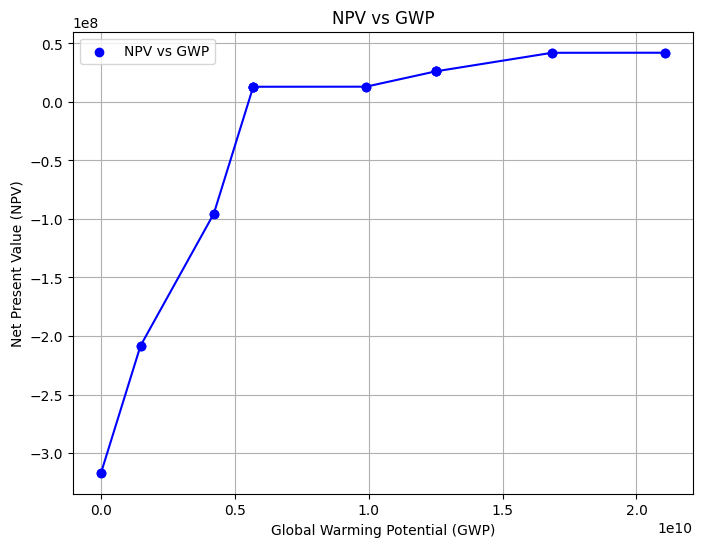

In [14]:

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(GWPs, NPVs, color='b', marker='o', label='NPV vs GWP')
plt.plot(GWPs, NPVs, color='b', linestyle='-', marker='o')

# Labels and title
plt.xlabel('Global Warming Potential (GWP)')
plt.ylabel('Net Present Value (NPV)')
plt.title('NPV vs GWP')

# Grid and legend
plt.grid(True)
plt.legend()

# Show plot
plt.show()
